## Image Segmentation

zID: z5392319

Name: Yifei Yue

### Imports

In [11]:
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

from scipy import ndimage as ndi
from skimage.segmentation import watershed
from skimage.feature import peak_local_max
from sklearn.cluster import MeanShift
# Required to calculate Dice Similarity Coefficient

from PIL import Image

# Reduce size of original image to reduce computation time
size = 150, 150 # change here

#### Function for displaying images

In [12]:
def plot_two_images(figure_title, image1, label1, image2, label2,
                    cmap1=None, cmap2=None):

    fig = plt.figure()
    fig.suptitle(figure_title)

    # Display the first image
    fig.add_subplot(1, 2, 1)
    plt.imshow(image1, cmap = cmap1)
    plt.axis('off')
    plt.title(label1)

    # Display the second image
    fig.add_subplot(1, 2, 2)
    plt.imshow(image2, cmap = cmap2)
    plt.axis('off')
    plt.title(label2)

    plt.show()

#### Function for applying MeanShift algorithm

In [13]:
def apply_meanshift(img):

    # TODO: Apply MeanShift to image
    # Consider the following hints as per the lab specification

    # Step 1 - Extract the three RGB colour channels
    img_mat = np.array(img)[:, :, :3]

    # Extract the three colour channels
    red = img_mat[:, :, 0]
    green = img_mat[:, :, 1]
    blue = img_mat[:, :, 2]

    # Step 2 - Store original image shape to be used later in resizing
    # Combine the three colour channels by flattening each channel
    # Then stack the flattened channels together
    # This gives the "colour_samples"
    original_shape = red.shape
    colour_samples = np.column_stack([red.flatten(), green.flatten(), blue.flatten()])


    # Step 3 - Perform MeanShift clustering
    # For larger images this may take a few minutes to compute
    ms_clf = MeanShift(bin_seeding=True)
    ms_labels = ms_clf.fit_predict(colour_samples)

    # Step 4 - Reshape ms_labels back to the original image shape
    # for displaying the segmentation output
    ms_labels = ms_labels.reshape(original_shape)

    return ms_labels

#### Function for applying Watershed algorithm

In [14]:
def apply_watershed(img, threshold=None, plotDistTransform = False):

    # TODO: Apply Watershed to image
    # Consider the following hints as per the lab specification
    # Step 1 - Convert the image to grayscale and then binary
    # and convert the image to a numpy matrix
    img_grey = img.convert('L')

    # Convert to binary image (note: can also use cv thresholding)
    if threshold is not None:
        img_grey = img_grey.point(lambda x: 0 if x < threshold else 255, '1')

    img_array = np.array(img_grey)

    # Step 2 - Calculate the distance transform
    # Hint: Use ndi.distance_transform_edt(img_array)
    distance = ndi.distance_transform_edt(img_array)

    # Remember to plot distance transform for Task 2

    # Step 3 - Generate the Watershed markers
    # Hint: Use the peak_local_max() function from the skimage.feature library
    # to get the local maximum values and then convert them to markers
    # Remember to change the local search region for good segmentation results
    # using ndi.label() (note the markers are the 0th output of this function)
    local_maxi = peak_local_max(distance, indices=False,
                                footprint=np.ones((6, 6)),
                                labels=img_array)

    markers = ndi.label(local_maxi)[0]

    # Step 4 - Perform Watershed and store the labels
    # Hint: Use the watershed() function from the skimage.morphology library
    # with three inputs: -distance, markers and your image array as a mask
    ws_labels = watershed(-distance, markers, mask=img_array)

    return ws_labels, distance

### Q1. Use the MeanShift algorithm for image segmentation

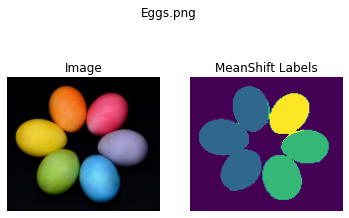

In [15]:
# Specify path to the test image
img_path = 'Eggs.png'

# Read image
img = Image.open(img_path)
img.thumbnail(size)

# Apply MeanShift algorithm to the image
ms_labels = apply_meanshift(img)   # change here

# Read and plot the original image and MeanShift result
img = mpimg.imread(img_path) # change here

plot_two_images(img_path, img, "Image", ms_labels, "MeanShift Labels")

### Q2. Use Watershed transformation for image segmentation

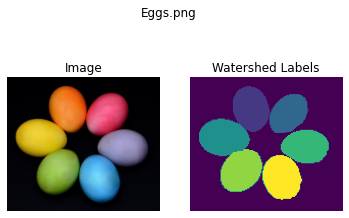

In [16]:
# Read image from img_path as specified above
img = Image.open(img_path)
# print(img.shape)
img.thumbnail(size)

# Apply Watershed algorithm (remember to plot distance transform as well)
ws_labels, distance = apply_watershed(img, threshold=75) # Change here

# Read the original image
img = mpimg.imread(img_path) # change here

plot_two_images(img_path, img, "Image", ws_labels, "Watershed Labels")

### Q3. Compare MeanShift and Watershed segmentation results

In [17]:
import pandas as pd

# List of MaskX.png images
MaskX = ['Mask{}.png'.format(str(idx)) for idx in range(1,7)]

# Generate list of unique MeanShift labels and corresponding label image masks
lbl_ms_unique, lbl_ms_counts = np.unique(ms_labels, return_counts=True)
ms_dscs = []
# Generate list of unique Watershed labels and corresponding label image masks
# Hint: Make sure you have generated reasonable watershed segmentation results
lbl_ws_unique, lbl_ws_counts = np.unique(ws_labels, return_counts=True)
ws_dscs = []

masks = ['Mask {}'.format(str(idx)) for idx in range(1,7)]
masks.append('Average')

# Iterate over MaskX.png images and calculate DSC
for each_maskx_image in MaskX:

    # Read each MaskX.png image
    img = Image.open(each_maskx_image)
    img.thumbnail(size)
    img_grey = img.convert('L')
    img_grey = img_grey.point(lambda x: 0 if x < 150 else 255, '1')
    ground_truth = np.array(img_grey)
    unique, counts = np.unique(ground_truth, return_counts=True)
    ground_truth_counts = counts[1:].sum()
    # Check DSC for each MeanShift label
    label_ms_dscs = []
    for label, label_counts in zip(lbl_ms_unique, lbl_ms_counts):
        intersection_counts = 0
        (row, col) = ms_labels.shape
        for r in range(row):
            for c in range(col):
                if ground_truth[r][c] == True and ms_labels[r][c] == label:
                    intersection_counts += 1
        dsc_value = (2. * intersection_counts) / (ground_truth_counts + label_counts)
        label_ms_dscs.append(dsc_value)
    ms_dscs.append(max(label_ms_dscs))
    # Check DSC for each Watershed label
    label_ws_dscs = []
    for label, label_counts in zip(lbl_ws_unique, lbl_ws_counts):
        intersection_counts = 0
        (row, col) = ws_labels.shape
        for r in range(row):
            for c in range(col):
                if ground_truth[r][c] == True and ws_labels[r][c] == label:
                    intersection_counts += 1
        dsc_value = (2. * intersection_counts) / (ground_truth_counts + label_counts)
        label_ws_dscs.append(dsc_value)
    ws_dscs.append(max(label_ws_dscs))
ms_dscs.append(sum(ms_dscs)/len(ms_dscs))
ws_dscs.append(sum(ws_dscs)/len(ws_dscs))


df = pd.DataFrame(list(zip(masks, ms_dscs, ws_dscs)), columns =['DSC', 'MeanShift', 'Watershed'])

print(df.to_string(index=False))


    DSC  MeanShift  Watershed
 Mask 1   0.479550   0.977183
 Mask 2   0.952268   0.919192
 Mask 3   0.611795   0.943969
 Mask 4   0.675019   0.950000
 Mask 5   0.471496   0.955556
 Mask 6   0.519392   0.986438
Average   0.618253   0.955390


### Discussion

From the obtained table, we can find that the performance of the watershed algorithm is much better than that of the meanshift drift algorithm, and the DSC of each mask in the watershed algorithm is above 0.9. The reason is that compared to the meanshift algorithm, the watershed algorithm has a good response to weak edges, which is the guarantee of generating closed continuous edges. The noise in the image and the subtle gray changes on the object surface may cause excessive segmentation. Therefore, Gaussian filtering can be used to avoid the local minimum points in the image forming a small region by themselves